In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd '/content/drive/MyDrive/주분3주차 패키지/data'

/content/drive/MyDrive/주분3주차 패키지/data


In [24]:
# 필요한 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random
import os

from sklearn.svm import SVC
from lightgbm import LGBMRegressor
import tensorflow as tf

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
# 시드고정
np.random.seed(2728)
random.seed(2728)
os.environ["PYTHONHASHSEED"] = str(2728)

# Chapter 1. SVM(Support Vector Machine)

## 문제 1. data1.csv 항목 불러오기

In [ ]:
svm_data = pd.read_csv("data1.csv")
# 불러온 데이터 확인
svm_data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


## 문제 2. target의 setosa를 0으로, versicolor을 1로, virginica를 2로 변경

In [ ]:
# map의 인자로 dict를 전달하여 값 변경
svm_data['target'] = svm_data['target'].map({'setosa' : 0, 'versicolor' : 1, 'virginica' : 2})

In [ ]:
# 변경된 값 확인
svm_data['target'].value_counts()

2    50
1    50
0    50
Name: target, dtype: int64

## 문제 3. Train Test Split(Test의 비율은 0.3)

In [ ]:
# Train, Test 분리 전 X와 y값 우선 분리
# X는 sepal length와 sepal width만 사용
X = svm_data.iloc[:, 0:2]
y = svm_data.iloc[:, -1]

In [ ]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2728)

## 문제 4. SVM의 하이퍼파라미터에 대한 설명
* C는 regularization parameter, penalty parameter로 분류 오차에 대한 비용을 조정한다. C값이 클수록 오차에 대한 비용이 커지고, C값이 작을수록 분류 오차에 덜 엄격해진다. 따라서 C값을 크게 할수록 학습 데이터에 대한 오버피팅 위험이 있다.
* kernel은 데이터를 분류하기 위한 초평면의 형태를 나타낸다.'linear'은 선형 경계를, 'rbf', 'poly', 'sigmoid'는 비선형 경계를 나타낸다.
* gamma는 kernel값이 비선형에 해당하는 경우에 쓰이며, gamma 값이 클수록 학습 데이터에 대한 오버피팅 위험이 있다.

## 문제 5. 하이퍼파라미터 튜닝 진행

In [ ]:
parameters = {
    'kernel' : ['linear'],
    'C' : [0.01, 0.1, 1, 10, 30, 50, 70]
}

model = SVC(random_state = 2728)

grid_search = GridSearchCV(model, param_grid = parameters, cv = 5, scoring = 'accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=2728, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.1, 1, 10, 30, 50, 70],
                         'kernel': ['linear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

## 문제 6. 최적 파라미터의 조합과 결과 출력

In [ ]:
print('best parameters : ', grid_search.best_params_)
print('best score : ', grid_search.best_score_)

best parameters :  {'C': 1, 'kernel': 'linear'}
best score :  0.819047619047619


## 문제 7. 테스트셋을 예측한 후 결과 출력

In [ ]:
# refit = True인 경우 최적의 파라미터 조합으로 전체 훈련 데이터에 대한 모델 학습을 진행하므로 아래의 두 줄은 사실 필요 없음(default가 True임)
model = SVC(C = 1, kernel = 'linear', random_state = 2728)
model.fit(X_train, y_train)

# test set에 대한 예측 시행
y_pred = model.predict(X_test)

In [ ]:
# 혼동행렬 확인
print('confusion matrix :\n', confusion_matrix(y_test, y_pred))

confusion matrix :
 [[20  0  0]
 [ 0  7  3]
 [ 0  7  8]]


## 문제 8. Decision Boundary 시각화

아래의 두 자료를 참고하여 시각화를 진행했습니다.  
[참고자료1](https://stackoverflow.com/questions/51297423/plot-scikit-learn-sklearn-svm-decision-boundary-surface) Plot different SVM classifiers in the iris dataset  
[참고자료2](https://scikit-learn.org/0.18/auto_examples/svm/plot_iris.html) Plot scikit-learn (sklearn) SVM decision boundary / surface  

In [ ]:
def make_meshgrid(X, h = 0.02):
  x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
  y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
  return xx, yy

In [ ]:
def plot_decision_boundary(X, xx, yy):
  result = model.predict(np.c_[xx.ravel(), yy.ravel()])
  result = result.reshape(xx.shape)

  plt.contourf(xx, yy, result, cmap = plt.cm.coolwarm, alpha=0.8)
  plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c = y, cmap = plt.cm.coolwarm)
  plt.xlabel('Sepal length')
  plt.ylabel('Sepal width')
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())
  plt.xticks(())
  plt.yticks(())
  plt.title('SVM')

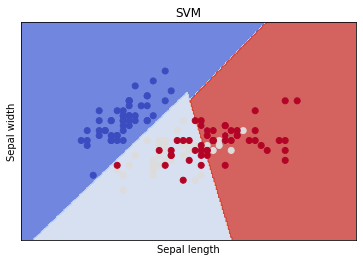

In [ ]:
xx, yy = make_meshgrid(X)
plot_decision_boundary(X, xx, yy)

# Chapter 2. LGBM

## 문제 1. data2.csv 불러오기

In [ ]:
lgbm_data = pd.read_csv('data2.csv')
lgbm_data.head()

,target,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,4.526,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,3.585,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,3.521,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,3.413,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.422,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


## 문제 2. Train Test Split(Test의 비율은 0.3)

In [ ]:
# Train, Test 분리 전 X와 y값 우선 분리
X = lgbm_data.iloc[:, 1:]
y = lgbm_data.iloc[:, 0]

In [ ]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2728)

## 문제 3. LGBM 파라미터에 대한 설명
* learning rate는 boosting step을 반복적으로 수행할 때 업데이트되는 학습률이다. learning rate를 작게 하면 예측 성능을 향상시킬 수는 있으나 학습 시간이 오래 걸린다.
* max_depth는 트리의 최대 깊이를 나타낸다. 값이 클수록 과적합 위험이 있고, LGBM은 leaf-wise이므로 깊이가 상대적으로 더 깊다.
* min_child_weight는 추가적으로 가지를 나눌지를 판단하기 위한 데이터들의 가중치 총합으로, 이 값이 클수록 분할을 자제하여 과적합을 조절한다.
* n_estimators은 약한 학습기의 개수로, 개수가 많을수록 성능이 일정 수준까지는 좋아지지만 개수가 많을수록 학습 시간이 오래걸린다.
* subsample은 약한 학습기가 학습에 사용하는 데이터의 샘플링 비율이다. 과적합 방지를 위해 1보다 작은 값으로 설정할 수 있다.
* colsample_bytree는 칼럼에 대한 샘플링을 하는 데 사용되며, 과적합을 조정한다.
* alpha는 L1 Regularization에 대한 값으로 과적합을 조정한다.

## 문제 4. LGBM 하이퍼파라미터 튜닝

In [ ]:
# GridSearchCVf를 이용하여 최적의 하이퍼파라미터 조합 찾기
model = LGBMRegressor(random_state = 2728)

parameters = {'learning_rate': [0.01, 0.02],
                'max_depth' : [10, 20],
                'min_child_weight': [1, 2],
                'n_estimators': [500, 1000],
                'subsample': [0.6, 0.7],
                'colsample_bytree' : [1.0],
                'alpha' : [0.9, 1],
                'objective' : ['regression'],
                'metric' : ['rmse']}

grid_search = GridSearchCV(estimator = model, cv = 5, param_grid = parameters, verbose = True)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:  9.0min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=2728,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True...
                                     subsample_freq=0),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.9, 1], 'colsample_bytree': [1.0],
                         'learning_rate': [0.01, 0.02], 'max_depth': [10, 20],
                         'metric': ['rmse'], 'min_child_weight': [1, 2],
                         'n_estim

## 문제 5. 최적의 파라미터 결과 출력

In [ ]:
print('best parameters : ', grid_search.best_params_)
print('best score : ', grid_search.best_score_)

best parameters :  {'alpha': 0.9, 'colsample_bytree': 1.0, 'learning_rate': 0.02, 'max_depth': 20, 'metric': 'rmse', 'min_child_weight': 1, 'n_estimators': 1000, 'objective': 'regression', 'subsample': 0.6}
best score :  0.8409826800534546


## 문제 6. 테스트셋에 대하여 예측한 후 결과 출력

In [ ]:
# 위에서 도출된 최적의 파라미터를 이용하여 모델 학습
model = LGBMRegressor(alpha = 0.9, 
                      colsample_bytree = 1.0, 
                      learning_rate = 0.02, 
                      max_depth = 20, 
                      metric = 'rmse', 
                      min_child_weight = 1, 
                      n_estimators = 1000, 
                      objective = 'regression', 
                      subsample = 0.6, 
                      random_state = 2728)

model.fit(X_train, y_train, eval_set = [(X_test, y_test)], eval_metric = 'rmse', early_stopping_rounds = 100, verbose = 100)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 0.573301
[200]	valid_0's rmse: 0.488877
[300]	valid_0's rmse: 0.470941
[400]	valid_0's rmse: 0.463099
[500]	valid_0's rmse: 0.457495
[600]	valid_0's rmse: 0.454576
[700]	valid_0's rmse: 0.452094
[800]	valid_0's rmse: 0.450292
[900]	valid_0's rmse: 0.448676
[1000]	valid_0's rmse: 0.448271
Did not meet early stopping. Best iteration is:
[989]	valid_0's rmse: 0.44827


LGBMRegressor(alpha=0.9, boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, importance_type='split', learning_rate=0.02,
              max_depth=20, metric='rmse', min_child_samples=20,
              min_child_weight=1, min_split_gain=0.0, n_estimators=1000,
              n_jobs=-1, num_leaves=31, objective='regression',
              random_state=2728, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=0.6, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
# 테스트셋을 이용하여 예측
y_pred = model.predict(X_test)

In [ ]:
# rmse 계산
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('rmse :', rmse)

rmse : 0.4482698811620094


# Chapter 3. LSTM

## 문제 1. Samsung.csv 불러오기

In [5]:
lstm_data = pd.read_csv('Samsung.csv')
lstm_data.head()

,Date,Price,Open,High,Low,Vol.
0,2019-10-01,"48,850","48,900","49,100","48,650",6.20M
1,2019-10-02,"47,600","48,350","48,400","47,600",8.37M
2,2019-10-03,"47,600","47,600","47,600","47,600",-
3,2019-10-04,"48,000","47,400","48,650","47,350",8.46M
4,2019-10-06,"48,000","48,000","48,000","48,000",-


## 문제 2. 데이터 형식 확인 및 수치형 변수 변환 

In [6]:
# 열과 행 개수 확인
lstm_data.shape

(627, 6)

In [7]:
# 데이터의 형식 확인
lstm_data.dtypes

Date     object
Price    object
Open     object
High     object
Low      object
Vol.     object
dtype: object

In [8]:
# 수치형 변수에 해당하는 값들의 comma를 모두 지운 후 float 64로 변환하는 함수 만들기
def to_numeric(x):
  x_converted = x.replace(',','')
  x_converted = np.float64(x_converted)
  return x_converted

In [9]:
# 각 칼럼의 comma를 지우고 float 64로 변환
lstm_data['Price'] = lstm_data['Price'].apply(to_numeric)
lstm_data['Open'] = lstm_data['Open'].apply(to_numeric)
lstm_data['High'] = lstm_data['High'].apply(to_numeric)
lstm_data['Low'] = lstm_data['Low'].apply(to_numeric)

In [10]:
# 변환 결과 확인
lstm_data.head()

,Date,Price,Open,High,Low,Vol.
0,2019-10-01,48850.0,48900.0,49100.0,48650.0,6.20M
1,2019-10-02,47600.0,48350.0,48400.0,47600.0,8.37M
2,2019-10-03,47600.0,47600.0,47600.0,47600.0,-
3,2019-10-04,48000.0,47400.0,48650.0,47350.0,8.46M
4,2019-10-06,48000.0,48000.0,48000.0,48000.0,-


In [11]:
# 데이터 형식 변환 잘 되었는지 확인
lstm_data.dtypes

Date      object
Price    float64
Open     float64
High     float64
Low      float64
Vol.      object
dtype: object

## 문제 3. 테스트 데이터 분리

In [12]:
# 최근 60일이 테스트 데이터이므로 60일을 기준으로 데이터 분리
train = lstm_data[:-60]
test = lstm_data[-60:]

In [13]:
# 분리 후 데이터의 행과 열 개수 확인
print(train.shape)
print(test.shape)

(567, 6)
(60, 6)


## 문제 4. Train과 Test에 대한 스케일링 시행

In [14]:
# train, test 모두에 적용해야 하므로 스케일링을 진행하는 함수 생성
def scale_columns(df):
  scaler = MinMaxScaler()
  df_scaled = scaler.fit_transform(df[['Price', 'Open', 'High', 'Low']])
  df_scaled = pd.DataFrame(df_scaled)
  df_scaled.columns = ['Price', 'Open', 'High', 'Low']
  return df_scaled

In [15]:
# 각 데이터셋에 대한 스케일링 진행
train_scaled = scale_columns(train)
test_scaled = scale_columns(test)

In [16]:
# train의 스케일링 결과 확인
train_scaled.head()

,Price,Open,High,Low
0,0.130928,0.131524,0.104421,0.133124
1,0.105155,0.120042,0.091251,0.111111
2,0.105155,0.104384,0.076199,0.111111
3,0.113402,0.100209,0.095955,0.105870
4,0.113402,0.112735,0.083725,0.119497


In [17]:
# test의 스케일링 결과 확인
test_scaled.head()

,Price,Open,High,Low
0,0.606742,0.629213,0.679012,0.629213
1,0.573034,0.584270,0.617284,0.528090
2,0.483146,0.539326,0.592593,0.528090
3,0.438202,0.539326,0.530864,0.460674
4,0.438202,0.449438,0.382716,0.483146


## 문제 5. Window Size에 맞게 Train과 Test 구성

In [18]:
# 피처와 타겟 분리
X = train_scaled[['Open', 'High', 'Low']]
y = train_scaled[['Price']]

In [19]:
# window size에 맞게 데이터를 구성하는 함수 정의
def to_ts_data(X, y, window_size = 20):
  X_list = []
  y_list = []

  for i in range(len(X) - window_size):
    X_list.append(np.array(X.iloc[i : i + window_size]))
    y_list.append(np.array(y.iloc[i + window_size]))
  
  return np.array(X_list), np.array(y_list)

In [20]:
# train, validation set 구성
X, y = to_ts_data(X, y, 20)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2)

In [21]:
print(X_train.shape)
print(y_train.shape)

(437, 20, 3)
(437, 1)


In [22]:
# test set에 대해서도 똑같이 구성
X_test = test_scaled[['Open', 'High', 'Low']]
y_test = test_scaled[['Price']]

X_test, y_test = to_ts_data(X_test, y_test, 20)

In [23]:
print(X_test.shape)
print(y_test.shape)

(40, 20, 3)
(40, 1)


## 문제 6. LSTM 모델링

In [34]:
model = Sequential()
model.add(LSTM(units = 16,
               input_shape = (X_train.shape[1], X_train.shape[2]),
               activation = 'relu',
               return_sequences = False))
model.add(Dense(128))
model.add(Dropout(0.2))
model.add(Dense(64))
model.add(Dense(1))

model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mse'])

## 문제 7. 모델 적합 후 결과 확인

In [35]:
es = EarlyStopping(patience = 10)
mc = ModelCheckpoint(filepath = 'lstm.h5', monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'auto')

In [36]:
model.fit(X_train, y_train, epochs = 100, batch_size = 32,
          validation_data = (X_valid, y_valid),
          callbacks = [es, mc])

Epoch 1/100
 8/14 [================>.............] - ETA: 0s - loss: 0.1285 - mse: 0.1285 
Epoch 00001: val_loss improved from inf to 0.03318, saving model to lstm.h5
14/14 [==============================] - 2s 34ms/step - loss: 0.0893 - mse: 0.0893 - val_loss: 0.0332 - val_mse: 0.0332
Epoch 2/100
13/14 [==========================>...] - ETA: 0s - loss: 0.0149 - mse: 0.0149
Epoch 00002: val_loss improved from 0.03318 to 0.01263, saving model to lstm.h5
14/14 [==============================] - 0s 15ms/step - loss: 0.0149 - mse: 0.0149 - val_loss: 0.0126 - val_mse: 0.0126
Epoch 3/100
12/14 [========================>.....] - ETA: 0s - loss: 0.0072 - mse: 0.0072
Epoch 00003: val_loss improved from 0.01263 to 0.00334, saving model to lstm.h5
14/14 [==============================] - 0s 14ms/step - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 4/100
13/14 [==========================>...] - ETA: 0s - loss: 0.0035 - mse: 0.0035
Epoch 00004: val_loss improved from 0.00334

## 문제 8. 테스트 데이터에 대해 예측 후 결과 시각화

In [37]:
# test에 대하여 예측
model.load_weights('lstm.h5')
y_pred = model.predict(X_test)

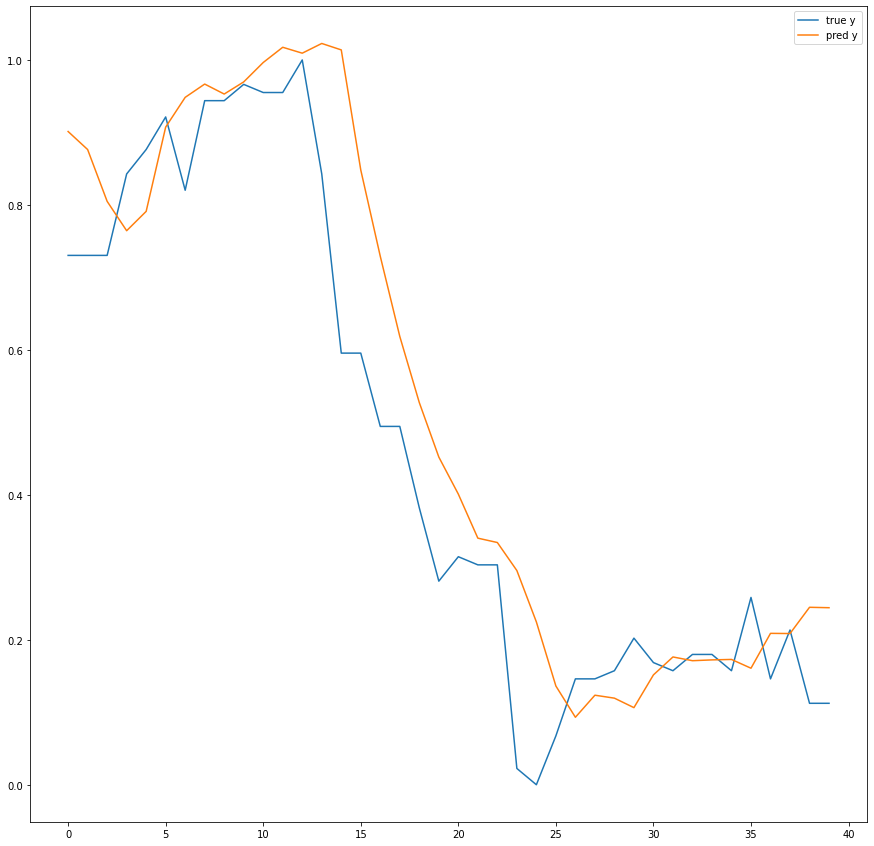

In [38]:
# 결과 시각화
plt.figure(figsize=(15, 15))
plt.plot(y_test, label = 'true y')
plt.plot(y_pred, label = 'pred y')
plt.legend()
plt.show()